In [1]:
import pandas as pd
import numpy as np
#Packages below are required only for visualization
import matplotlib.pyplot as plt
from scipy import stats

### Rergression estimator of the target class area for simple random sampling, from Tyukavina et al. (2025) "Practical global sampling methods for estimating area and map accuracy of land cover and change" [https://doi.org/10.1016/j.rse.2025.114714](https://doi.org/10.1016/j.rse.2025.114714), Appendix B.1.

#### Example of input data

In [2]:
#Define total number of units in the population
N = 27374
#Define population mean of the per-sample unit values of auxiliary class
X = 17.40936388
#(optional, might be needed to convert estimates to % of total area) Define the area of the sampling region (e.g. in km²)
Atot = 16775135.2

In [3]:
#Read sample interpretation table with columns:
#"yi": area of the target class in sample unit i,derived from sample interpretation (reference classification);
#"yi" should be in the same units as Atot;
#"xi": value of the auxiliary class for sample unit (e.g. area of land cover class from existing wall-to-wall map or 
#mean spectral index value within sample unit); 
#"xi" could be in any units matching X

data = pd.read_csv('B.1.Sample_data.txt', sep ='\t')

In [4]:
data.head().style.hide(axis="index")

yi,xi
83.221479,5.976763
135.121420,24.891103
4.841977,2.647889
49.932887,15.131386
0.983526,0.151314


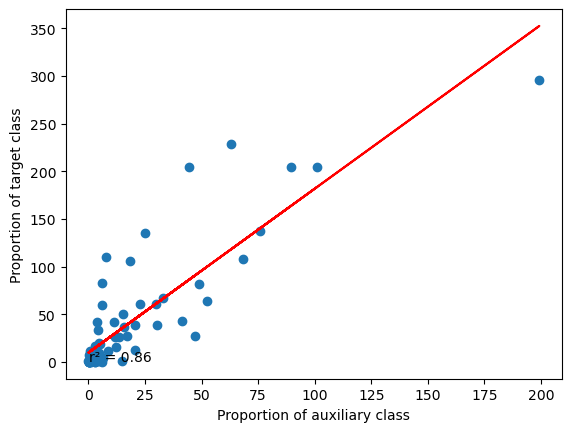

In [5]:
#Visualize linear regression between y and x

plt.scatter(data.xi,data.yi)
plt.xlabel('Proportion of auxiliary class')
plt.ylabel('Proportion of target class')

linreg = stats.linregress(data.xi, data.yi)
plt.plot(data.xi, linreg.intercept + linreg.slope*data.xi, 'r')

plt.text(0.25,0.4, 'r² = %0.2f' % linreg.rvalue)
plt.show()

#### Functions to produce regression estimate of target class area and its standard error

In [6]:
def estimate_area_reg(df: pd.DataFrame, N: int, X: float) -> float:
    """ 
    Function to produce regression estimator of target class area from sample refernce values 
    for equal probability sampling (non-stratified), when yi is defined in terms of area.
    ~~~
    Input variables:
    N (total number of units in the population)
    X (mean of the auxiliary class values for all N units in the population)
    
    Input dataframe with number of lines equal the number of sample pixels/polygons,
    and the following columns:
    "yi" area (e.g. in km2) of the target class in sample unit i, derived from sample interpretation (reference classification);
    "xi" value of the auxiliary class for sample unit (e.g. area of land cover class from existing wall-to-wall map or 
    mean spectral index value within sample unit); xi could be in any units matching X.
    ~~~
    Returns estimated target class area in units of yi 
    ~~~
    From Tyukavina et al. (in review) "Practical global sampling methods for estimating 
    area and map accuracy of land cover and change classes"
    Appendix B.1, equations B.1-B.2
    """
    df['y-ymean'] = df['yi'] - df['yi'].mean()
    df['x-xmean'] = df['xi'] - df['xi'].mean()
    
    #Equation B.2
    b = (df['y-ymean'] * df['x-xmean']).sum() / (df['x-xmean'] * df['x-xmean']).sum()
    
    #Equation B.1
    area = N * (df['yi'].mean() + b * (X - df['xi'].mean()))

    return area

In [7]:
estimate_area_reg(data, N, X)

1086017.079202585

In [8]:
def estimate_area_SE_reg(df: pd.DataFrame, N: int) -> float:
    """ 
    Function to estimate SE of the regression estimate of target class area from sample refernce values 
    for equal probability sampling (non-stratified), when yi is defined in terms of area.
    ~~~
    Input variables:
    N (total number of units in the population)
    
    Input dataframe with number of lines equal the number of sample pixels/polygons,
    and the following columns:
    "yi" area (e.g. in km2) of the target class in sample unit i, derived from sample interpretation (reference classification);
    "xi" value of the auxiliary class for sample unit (e.g. area of land cover class from existing wall-to-wall map or 
    mean spectral index value within sample unit); xi could be in any units matching X.
    ~~~
    Returns estimated target class area in units of yi
    ~~~
    From Tyukavina et al. (in review) "Practical global sampling methods for estimating 
    area and map accuracy of land cover and change classes"
    Appendix B.1, equation B.3
    """
    df['y-ymean'] = df['yi'] - df['yi'].mean()
    df['x-xmean'] = df['xi'] - df['xi'].mean()
    
    #Equation B.3
    ForVar = (df['y-ymean'] * df['y-ymean']).sum() - (df['y-ymean'] * df['x-xmean']).sum() * (df['y-ymean'] * df['x-xmean']).sum() / (df['x-xmean'] * df['x-xmean']).sum()
    n = df['yi'].count()
    Var = N**2 * ForVar * (1 - n/N) / (n * (n-2))
    
    SE = np.sqrt(Var)

    return SE

In [9]:
estimate_area_SE_reg(data, N)

106327.70099311872

#### Direct estimate of the target class area (for comparison with regression estimate)

In [10]:
def estimate_area_dir(df: pd.DataFrame, N: int) -> float:
    """ 
    Function to produce direct estimator of target class area from sample refernce values 
    for equal probability sampling (non-stratified), when yi is defined in terms of area.
    ~~~
    Input variables:
    N (total number of units in the population)
    
    Input dataframe with number of lines equal the number of sample pixels/polygons,
    and the following column:
    "yi" area (e.g. in km2) of the target class in sample unit i, derived from sample interpretation (reference classification);
    ~~~
    Returns estimated target class area in units of yi 
    ~~~
    From Tyukavina et al. (in review) "Practical global sampling methods for estimating 
    area and map accuracy of land cover and change classes"
    Appendix A1.1, equation A.7, H = 1
    """
    area = df['yi'].mean() * N

    return area

In [11]:
estimate_area_dir(data, N)

1116448.854282674

In [12]:
def estimate_area_SE_dir(df: pd.DataFrame, N: int) -> float:
    """ 
    Function to estimate SE of the direct estimate of target class area from sample refernce values 
    for equal probability sampling (non-stratified), when yi is defined in terms of area.
    ~~~
    Input variables:
    N (total number of units in the population)
    
    Input dataframe with number of lines equal the number of sample pixels/polygons,
    and the following columns:
    "yi" area (e.g. in km2) of the target class in sample unit i, derived from sample interpretation (reference classification);
    ~~~
    Returns estimated target class area in units of yi 
    ~~~
    From Tyukavina et al. (in review) "Practical global sampling methods for estimating 
    area and map accuracy of land cover and change classes"
    Appendix A1.1, equation A.8, H = 1
    """
    n = df['yi'].count()
    Var = df['yi'].var(ddof=1) / n * (1 - n/N) * N**2
    
    SE = np.sqrt(Var)

    return SE

In [13]:
estimate_area_SE_dir(data, N)

205535.113223563